# Interactive Music Generation with LSTM models

github source: https://github.com/ual-cci/music_gen_interaction_RTML

docker (needs GPU): https://hub.docker.com/repository/docker/previtus/demo-lstm-music-gen



examples of generated music (with spectrogram visualizations): https://ual-cci.github.io/vitek/ml_gen_music/report_griff_lim.html?version=61bf4b0

video of proto versions of the interactive interface (not used here in this command line example - Colab can't show proper GUI...): https://www.youtube.com/watch?v=w7Sk7RTVs9U

![Example of the generated audio:](https://ual-cci.github.io/vitek/ml_gen_music/report_griff_lim/Model_masu_radio_future_mp3_wav3x128_sample22khz_griff60__train300epX64bt__sample_0.png)


## Install prerequisites and get code

In [ ]:
%tensorflow_version 1.x
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # less warnings ...
import tensorflow as tf

TensorFlow 1.x selected.


In [ ]:
!git clone https://github.com/ual-cci/music_gen_interaction_RTML.git

Cloning into 'music_gen_interaction_RTML'...
remote: Enumerating objects: 530, done.
remote: Counting objects: 100% (530/530), done.
remote: Compressing objects: 100% (322/322), done.
remote: Total 530 (delta 331), reused 396 (delta 205), pack-reused 0
Receiving objects: 100% (530/530), 11.62 MiB | 39.66 MiB/s, done.
Resolving deltas: 100% (331/331), done.


In [ ]:
# python libraries
!pip install Pillow numpy opencv-python PyWavelets tqdm slugify
!pip install -U Flask
!pip install lws==1.2.6
!pip install tflearn
!pip install librosa==0.7.2
!pip install numba==0.48
!pip install mock

In [ ]:
!pip install numba==0.48

In [ ]:
%cd /content/music_gen_interaction_RTML

/content/music_gen_interaction_RTML


## Download a sample audio:

Note: replace the url with whatever music video you want - or upload a file directly ... You can use the ffmpeg to convert it to wav later.

In [ ]:
# get a youtube downloader
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     3    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     3    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100   614  100   614    0     0    554      0  0:00:01  0:00:01 --:--:--   554
100 1765k  100 1765k    0     0  1453k      0  0:00:01  0:00:01 --:--:-- 1453k


In [ ]:
# get available formats
# Brad Mehldau - Don't Be Sad
!youtube-dl -F https://www.youtube.com/watch?v=_MOpX3R7CwY

[youtube] _MOpX3R7CwY: Downloading webpage
[youtube] _MOpX3R7CwY: Downloading player 1c732901
[info] Available formats for _MOpX3R7CwY:
format code  extension  resolution note
249          webm       audio only tiny   53k , opus @ 53k (48000Hz), 3.16MiB
250          webm       audio only tiny   75k , opus @ 75k (48000Hz), 4.43MiB
140          m4a        audio only tiny  127k , mp4a.40.2@127k (44100Hz), 7.45MiB
251          webm       audio only tiny  179k , opus @179k (48000Hz), 10.54MiB
160          mp4        256x144    144p   19k , avc1.4d400c@  19k, 30fps, video only, 1.12MiB
278          webm       256x144    144p   42k , vp9@  42k, 30fps, video only, 2.48MiB
133          mp4        426x240    240p   34k , avc1.4d4015@  34k, 30fps, video only, 2.02MiB
242          webm       426x240    240p   56k , vp9@  56k, 30fps, video only, 3.33MiB
134          mp4        640x360    360p   87k , avc1.4d401e@  87k, 30fps, video only, 5.15MiB
243          webm       640x360    360p  105k , vp9@ 

In [ ]:
!youtube-dl -ci -f "bestaudio[ext=m4a]" https://www.youtube.com/watch?v=_MOpX3R7CwY

[youtube] _MOpX3R7CwY: Downloading webpage
[download] Destination: Brad Mehldau - Don't Be Sad-_MOpX3R7CwY.m4a
[download] 100% of 7.45MiB in 00:00


In [ ]:
!ls -luah *.m4a

-rw-r--r-- 1 root root 7.5M Feb 20 19:58 "Brad Mehldau - Don't Be Sad-_MOpX3R7CwY.m4a"


In [ ]:
!ffmpeg -i "Brad Mehldau - Don't Be Sad-_MOpX3R7CwY.m4a" -ac 2 -f wav jazz_full.wav

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
# let's get only the first minute from it!
!ffmpeg -ss 60 -i jazz_full.wav -t 60 -c copy jazz_sample.wav
#< -ss 60 means, "start from second 60"
#< -t 60 audio output length in seconds.. in this case, 1 minute..

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
!ls -luah *.wav

-rw-r--r-- 1 root root 83M Feb 20 19:58 jazz_full.wav
-rw-r--r-- 1 root root 11M Feb 20 19:58 jazz_sample.wav


In [ ]:
!mkdir audio_data_source
!mv jazz_sample.wav audio_data_source/
# put all the wav files you want the model to train on into this folder ^

In [ ]:
!ls -luah audio_data_source/*.wav

-rw-r--r-- 1 root root 11M Feb 20 19:58 audio_data_source/jazz_sample.wav


## Train a model:

In [ ]:
!python training_handler.py --help
"""
usage: training_handler.py [-h] [-target_file TARGET_FILE]
                           [-lstm_layers LSTM_LAYERS] [-lstm_units LSTM_UNITS]
                           [-griffin_iterations GRIFFIN_ITERATIONS]
                           [-sample_rate SAMPLE_RATE]
                           [-amount_epochs AMOUNT_EPOCHS]
                           [-batch_size BATCH_SIZE]
                           [-sequence_length SEQUENCE_LENGTH]
"""
True

In [ ]:
# we can keep the default values, but let's change the amount of epochs to lower to speed things up

# time:
# - 1 minute of 22050hz audio with model of 3 layers * 128 units
#   with batch size 64: cca 10 sec per epoch (cca 9 min for 50 epochs ...)
#   with batch size 512: cca 1.5 sec (7.5 min for 300 epochs)

# [optionally] - we can edit what the model looks like (but for first experiments I recommend sticking to the default values)

!mkdir __saved_models/
!python training_handler.py -target_file audio_data_source/ -amount_epochs 300 -batch_size 512

In [ ]:
# PS: more manual approach is possible, we can take a look into training_handler.py and reuse some of the code there ...

## Results and interaction with the model:

In [ ]:
!ls __saved_models/

checkpoint
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl.data-00000-of-00001
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl.index
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl.meta
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl.png
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_0.wav
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_1.wav
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_2.wav
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_3.wav
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_4.wav
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl.settings


In [ ]:
#!rm __saved_models/Model_3x128_sample22khz_griff60__train50ep* #< delete possible old models / (alternatively move them)

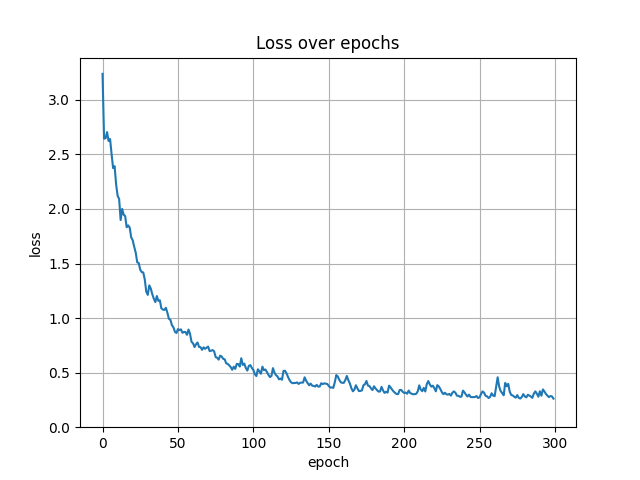

In [ ]:
# Show the previously saved image of the training progress
name = "Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl"

from IPython.display import Image
Image('__saved_models/'+name+".png")

In [ ]:
# we automatically generated some initial sample (later we will have more power over them though ... this is just a preview!)
from IPython.display import Audio
i = 1
Audio('__saved_models/'+name+"_sample_"+str(i)+".wav")

In [ ]:
# more reports with spectrograms can be generated using:
!python report_handler.py -folder __saved_models/
# << ignore the error at the end :D







Settings:
	- server_model_paths_start: __saved_models/
	- server_songs_paths_start: __music_samples/
Server settings: settings.lstm_layers= None , settings.lstm_units= None , settings.griffin_iterations= None , settings.sample_rate= None
[[[[ Reporting model 0 / 1 : Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl.data-00000-of-00001
__saved_models/Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl
audio_data_source/
Zero-padding symmetrically around the original windows.
100% data generation complete.Dataset: (2624, 40, 1025) (2624, 1025)
Loaded dataset.


Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





Instructions for updating:
Use tf.where in 2.0, which has th

In [ ]:
!ls reports/ 

custom.js
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_0.png
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_0.wav
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_1.png
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_1.wav
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_2.png
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_2.wav
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_3.png
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_3.wav
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_4.png
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_4.wav
Model_3x128_sample22khz_griff60__train50epX512bt__40seq.tfl_sample_0.png
Model_3x128_sample22khz_griff60__train50epX512bt__40seq.tfl_sample_0.wav
Model_3x128_sample22khz_griff60__train50epX512bt__40seq.tfl_sample_1.png
Model_3x128_sample22khz_griff60

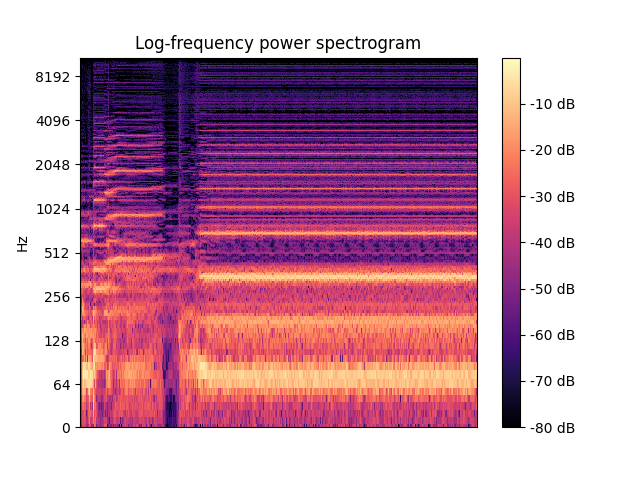

In [ ]:
from IPython.display import Audio, Image

i = 0
Image("reports/"+name+"_sample_"+str(i)+".png")

In [ ]:
Audio("reports/"+name+"_sample_"+str(i)+".wav")

In [ ]:
# music source for generation - we can reuse the same one we trained on
!cp -r audio_data_source/ __music_samples/

## Finally interaction!

In [ ]:
"""    
    parser = argparse.ArgumentParser(description='Project: Real Time Audio Generation.')
    parser.add_argument('-lstm_layers', help='number of LSTM layers the model should have (default and suggested value, 3)', default='3')
    parser.add_argument('-lstm_units', help='number of units in each LSTM layer (default and suggested value, 128)', default='128')
    parser.add_argument('-griffin_iterations', help='iterations to use in griffin reconstruction; lower number faster and lower quality of reconstructed signal (default value, 60)', default='60')
    parser.add_argument('-sample_rate', help='sampling rate under which we represent the music data (default and suggested value, 22050)', default='22050')
    parser.add_argument('-sequence_length', help='sequence length of each block of data when training on the task to predict the next single frame from this block of data (default and suggested value, 40)', default='40')
    parser.add_argument('-async_loading', help='async_loading, if we allow for async change between loaded models / songs', default='True')
"""
%cd /content/music_gen_interaction_RTML/

from unittest.mock import Mock, MagicMock
args = MagicMock(name='method')
sample_rate = 22050

# keep the same settings as the model you used when training:
args.lstm_layers = 3
args.lstm_units = 128
args.griffin_iterations = 60
args.sample_rate = sample_rate
args.sequence_length = 40
args.async_loading = True
args.amount_epochs = -1

/content/music_gen_interaction_RTML


In [ ]:
!ls __saved_models/
#!rm __saved_models/Model_3x128_sample22khz_griff60__train2ep* #<< delete some older models...

checkpoint
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl.data-00000-of-00001
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl.index
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl.meta
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl.png
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_0.wav
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_1.wav
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_2.wav
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_3.wav
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl_sample_4.wav
Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl.settings


In [ ]:
from server_handler import ServerHandler
import settings

my_settings = settings.Settings(args)
my_settings.print_settings()

generation_handler = ServerHandler(my_settings)

Settings:
	- server_model_paths_start: __saved_models/
	- server_songs_paths_start: __music_samples/
Server settings: settings.lstm_layers= 3 , settings.lstm_units= 128 , settings.griffin_iterations= 60 , settings.sample_rate= 22050
Settings:
	- server_model_paths_start: __saved_models/
	- server_songs_paths_start: __music_samples/
Server settings: settings.lstm_layers= 3 , settings.lstm_units= 128 , settings.griffin_iterations= 60 , settings.sample_rate= 22050
Zero-padding symmetrically around the original windows.
Created model: <tflearn.models.dnn.DNN object at 0x7f92e9aa5c18>
['__saved_models/Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl.data-00000-of-00001']
prepared 1 models and  2 songs.
We have loaded these songs and models (ps: their order should match, please name them accordingly):
models:
__saved_models/Model_3x128_sample22khz_griff60__train300epX512bt__40seq.tfl
songs:
__music_samples/.ipynb_checkpoints/
__music_samples/audio_data_source/
['__saved_models/Mo

From now on we have loaded the model and have a handler to it in the variable "generation_handler". Now let's use it to sample some audio...

In [ ]:
import librosa
from IPython.display import Audio, Image
from IPython.display import clear_output 

position_in_the_song = 0.4 # between 0.0 and 1.0 - corresponds to 0-100%
requested_length = 600 #number of samples to predict ...
                  #600 corresponds to ~13 sec

generation_handler.change_impulse(position_in_the_song)
audio_arr, t_predict, t_reconstruct = generation_handler.generate_audio_sample(requested_length, interactive_i=position_in_the_song)

# clear possible errors ...
clear_output()

print(audio_arr.shape)

out_name = 'generated_output.wav'
librosa.output.write_wav(out_name, audio_arr, sr=sample_rate)
Audio(out_name)

(306721,)


In [ ]:
# Load and show spectrogram:

import matplotlib.pyplot as plt
import numpy as np
import librosa.display

def show_spectrogram(y, sr):

  #y, sr = librosa.load(out_name)
  fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
  D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
  img1 = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                                sr=sr, ax=ax[0])
  ax[0].set(title='Linear-frequency power spectrogram')
  ax[0].label_outer()

  hop_length = 1024
  D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                              ref=np.max)
  img2 = librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                          x_axis='time', ax=ax[1])
  ax[1].set(title='Log-frequency power spectrogram')
  ax[1].label_outer()
  #fig.colorbar(img1, ax=ax, format="%+2.f dB")

def save_spectrogram_small(y, sr, name):
  hop_length = 1024
  fig = plt.figure(figsize=(12,4))
  D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                              ref=np.max)
  librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length, x_axis='time')
  plt.title('Log-frequency power spectrogram')
  plt.tight_layout()
  plt.savefig(name)
  plt.close()

# two uses:
#show_spectrogram(audio_arr, sample_rate)
#save_spectrogram_small(audio_arr, sample_rate, "demo.png")

In [ ]:
show_spectrogram(audio_arr, sample_rate)

In [ ]:
# Would you like to interact more directly with the insides?
# debug into insides of the various handlers:
print("input >",generation_handler.model_handler.model.inputs)
print("output >",generation_handler.model_handler.model.net)

print("data used as seed >", generation_handler.preloaded_impulses.shape)
# when you set position_in_the_song as 0.0 it will use the sample [0:40, 40, 1025] as input ...

input > [<tf.Tensor 'input_data0/X:0' shape=(?, 40, 1025) dtype=float32>]
output > Tensor("FullyConnected_1/BiasAdd:0", shape=(?, 1025), dtype=float32)
data used as seed > (2624, 40, 1025)


### Concatenation of outputs from the model at various times with interpolations through latent space

In [ ]:
# slightly experimental interpolation through the latents while generating ...

requested_length = 200

generation_handler.change_impulse(0.2) # set to 20% sharp

position_in_the_song = 0.3

generation_handler.change_impulse_smoothly_start(position_in_the_song) # allow interpolation
audio_arr_exp1, t_predict, t_reconstruct = generation_handler.generate_audio_sample(requested_length, interactive_i=position_in_the_song)

position_in_the_song = 0.6

generation_handler.change_impulse_smoothly_start(position_in_the_song)
audio_arr_exp2, t_predict, t_reconstruct = generation_handler.generate_audio_sample(requested_length, interactive_i=position_in_the_song)

position_in_the_song = 0.9

generation_handler.change_impulse_smoothly_start(position_in_the_song)
audio_arr_exp3, t_predict, t_reconstruct = generation_handler.generate_audio_sample(requested_length, interactive_i=position_in_the_song)

clear_output()

In [ ]:
import numpy as np

print(audio_arr_exp1.shape)
print(audio_arr_exp2.shape)
print(audio_arr_exp3.shape)
audio_arr_exp = np.concatenate([audio_arr_exp1,audio_arr_exp2,audio_arr_exp3])

out_name = 'generated_output_exp_concat.wav'
librosa.output.write_wav(out_name, audio_arr_exp, sr=sample_rate)
Audio(out_name)

(101974,)
(101974,)
(101974,)


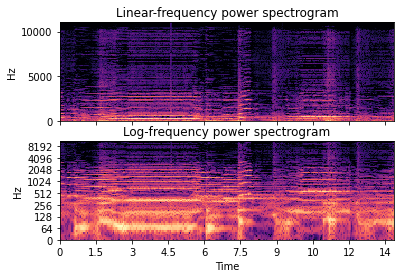

In [ ]:
show_spectrogram(audio_arr_exp, sample_rate)

## Links to more songs...

You can replace the above code with these links (take care to rename the files correctly though ... these will by default just save a "full.wav" and "sample.wav" files).



In [ ]:
# 1 Lykke Li - I Follow Rivers
#!youtube-dl -ci -f "bestaudio[ext=m4a]" https://www.youtube.com/watch?v=uY4q6I-dzE8
#!ffmpeg -i "Lykke Li - I Follow Rivers Original-uY4q6I-dzE8.m4a" -ac 2 -f wav full.wav

# 2 Radiohead - Everything in its Right Place
!youtube-dl -ci -f "bestaudio[ext=m4a]" https://www.youtube.com/watch?v=NUnXxh5U25Y
!ffmpeg -i 'Everything In Its Right Place-NUnXxh5U25Y.m4a' -ac 2 -f wav full.wav

# 3 M.O.O.N. - Hydrogen (Hotline Miami Soundtrack)
#!youtube-dl -ci -f "bestaudio[ext=m4a]" https://www.youtube.com/watch?v=SNE2oCZH_4k
#!ffmpeg -i "M.O.O.N. - 'Hydrogen' [Hotline Miami Soundtrack]-SNE2oCZH_4k.m4a" -ac 2 -f wav full.wav

# 4 Orbital - Halcyon
#!youtube-dl -ci -f "bestaudio[ext=m4a]" https://www.youtube.com/watch?v=3SwwljI-8JY
#!ffmpeg -i 'Orbital - Halcyon (Official Music Video)-3SwwljI-8JY.m4a' -ac 2 -f wav full.wav

number_of_epochs = 300 # will take cca 8min
number_of_epochs = 150 # will take cca 4min

# ----[keep the same bellow]-------------------------------------------------------------------
!ffmpeg -ss 60 -i full.wav -t 60 -c copy sample.wav
"""
!mkdir __music_samples
!mkdir __music_samples/sample/
!mv sample.wav __music_samples/sample/
!mkdir __saved_models/

# takes time!
!python training_handler.py -target_file __music_samples/sample/ -amount_epochs $number_of_epochs -batch_size 512
from IPython.display import clear_output 
clear_output()

import glob
l = glob.glob("__saved_models/*.wav")
a = l[np.random.randint(len(l))]
i = glob.glob("__saved_models/*.png")
from IPython.display import Audio, Image
display(Audio(a))
display(Image(i[0]))
"""